In [1]:
import numpy as np
import pandas as pd
import gym
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import torch

In [2]:
env= gym.make('LunarLander-v2')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class critic(nn.Module):
    def __init__(self,state_space,action_space):
        super(critic,self).__init__()
        self.fc1= nn.Linear(state_space,64)
        self.fc2= nn.Linear(64,64)
        self.fc3= nn.Linear(64,action_space)
    def forward(self,x):
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        return torch.squeeze(x,-1)

In [5]:
class ActorCritic(nn.Module):
    def __init__(self,state_space,action_space):
        super(ActorCritic,self).__init__()
        self.fc1= nn.Linear(state_space,64)
        self.fc2= nn.Linear(64,64)
        self.fc3= nn.Linear(64,action_space)
        self.v= critic(state_space,1).to(device)
    def forward(self,x):
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= (self.fc3(x))
        m= nn.Softmax(dim=-1)
        return m(x)
    def step(self,obs):
        with torch.no_grad():
            logits= self.forward(obs)
            pi= Categorical(logits)
            a= pi.sample()
            log_p= pi.log_prob(a)
            v= self.v(obs)
        return a.cpu().numpy(),v.cpu().numpy(), log_p.cpu().numpy()
    def act(self,obs):
        return self.step(obs)[0]
    def logp(self,obs,act):
        logits= self.forward(obs)
        pi= Categorical(logits)
        log_p= pi.log_prob(act)
        return log_p

In [6]:
actor_critic= ActorCritic(env.observation_space.shape[0],env.action_space.n).to(device)

In [7]:
ac_optimizer=optim.Adam(actor_critic.parameters(),lr=3e-4)
critic_optimizer= optim.Adam(actor_critic.v.parameters(),lr=1e-3)

In [8]:
def reward_to_go(rews):
    n = len(rews)
    rtgs = np.zeros_like(rews.cpu())
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
    return  rtgs

In [9]:
def update(state_batch,reward_batch,action_batch,v_batch,log_prob_batch,advantage_batch):
    clip_ratio=0.2
    #print(state_batch)
    state_batch= torch.as_tensor(state_batch,dtype=torch.float32).to(device)
    #print(state_batch)
    reward_batch= torch.as_tensor(reward_batch,dtype= torch.float32).to(device)
    #print(reward_batch)
    action_batch= torch.as_tensor(np.asarray(action_batch),dtype= torch.int32).to(device)
    #print(v_batch)
    v_batch= torch.as_tensor(np.asarray(v_batch),dtype= torch.int32).to(device)
    log_prob_old= torch.as_tensor(np.asarray(log_prob_batch), dtype= torch.float32).to(device)
    advantage= torch.as_tensor(np.asarray(advantage_batch), dtype= torch.float32).to(device)
    rtgs= torch.as_tensor(reward_to_go(reward_batch)).to(device)
    for i in range(10):
        log_prob= actor_critic.logp(state_batch,action_batch)
        ratio= torch.exp(log_prob-log_prob_old)
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * advantage
        loss_pi = -(torch.min(ratio * advantage, clip_adv)).mean()

        ac_optimizer.zero_grad()
        loss_pi.backward()
        ac_optimizer.step()

        loss_v= ((actor_critic.v(state_batch) - rtgs)**2).mean()
        critic_optimizer.zero_grad()
        loss_v.backward()
        critic_optimizer.step()

In [10]:
r_l=[]
for epoch in range(5000):
    state_batch=[]
    reward_batch=[]
    action_batch=[]
    v_batch=[]
    log_prob_batch=[]
    terminal_batch=[]
    advantage_batch=[]
    rewards=[]
    state= env.reset()
    done= False
    r=0
    while not done:
        #env.render()
        a,v_old,log_p= actor_critic.step(torch.as_tensor(state,dtype=torch.float32).to(device))
        #print(a)
        next_s, reward,done,_=env.step(a)
        state_batch.append(state)
        reward_batch.append(reward)
        action_batch.append(a)
        v_batch.append(v_old)
        log_prob_batch.append(log_p)
        terminal_batch.append(done)
        state=next_s
        r+=reward
        _,v_new,log_p=actor_critic.step(torch.as_tensor(state,dtype=torch.float32).to(device))
        adv= (reward+0.99*v_new)-v_old
        advantage_batch.append(adv)
    r_l.append(r)
    update(state_batch,reward_batch,action_batch,v_batch,log_prob_batch,advantage_batch)
    if epoch%40 == 9:
        print("Episode: ",epoch," Last avg reward: ",sum(r_l[-40:])/40)

/tmp/ipykernel_29080/675372631.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  state_batch= torch.as_tensor(state_batch,dtype=torch.float32).to(device)


Episode:  9  Last avg reward:  -48.37280191881203
Episode:  49  Last avg reward:  -276.6766908854629
Episode:  89  Last avg reward:  -314.8126200037885
Episode:  129  Last avg reward:  -199.23644835586475
Episode:  169  Last avg reward:  -179.68493480210867
Episode:  209  Last avg reward:  -161.13792899459364
Episode:  249  Last avg reward:  -124.30769152185269
Episode:  289  Last avg reward:  -87.5622940747326
Episode:  329  Last avg reward:  -57.57620022292964
Episode:  369  Last avg reward:  -73.29039695443461
Episode:  409  Last avg reward:  -48.3158775547592
Episode:  449  Last avg reward:  -61.36192268863389
Episode:  489  Last avg reward:  -57.316432492971344
Episode:  529  Last avg reward:  -41.046066495527626
Episode:  569  Last avg reward:  -51.63911603265078
Episode:  609  Last avg reward:  -21.228852721543937
Episode:  649  Last avg reward:  -7.4345963894390765
Episode:  689  Last avg reward:  -12.080862317660777
Episode:  729  Last avg reward:  -48.7898962275882
Episode:  

Text(0.5, 1.0, 'Rewards per episode in training by PPO')

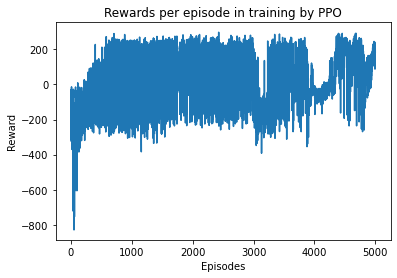

In [17]:
import matplotlib.pyplot as plt
plt.plot(r_l)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards per episode in training by PPO')

In [15]:
ev_l=[]
for epoch in range(50):
    done= False
    state= env.reset()
    r=0
    while not done:
        env.render()
        a,v_old,log_p= actor_critic.step(torch.as_tensor(state,dtype=torch.float32).to(device))
        #print(a)
        next_s, reward,done,_=env.step(a)
        r+=reward
        state= next_s
    ev_l.append(r)

Text(0.5, 1.0, 'Rewards per Episode in evaluation')

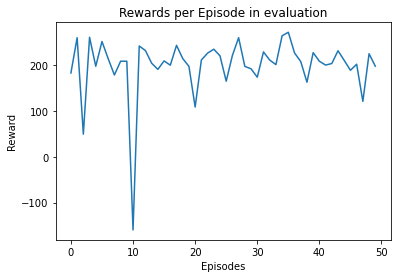

In [16]:
plt.plot(ev_l)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards per Episode in evaluation')